In [1]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib.pyplot as plt
import sys, time, os
import cvxpy as cvx
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import problems, projection, optimize, util
from tomo1D import blur_1d
from tomo2D import blur_2d

# test dimensions (dense)

In [5]:
def test_dim(mm=1, nn=2, kk=60, lamlam=None, ee=None):
    XX = np.random.randn(mm,nn)
    KK = np.diag(abs(np.random.randn(mm)))
    MM = np.eye(nn)[0:kk]

    ss = np.ones(mm)
    ss[0:int(0.4*mm)] = 0.
    ss[int(0.6*mm):] = 0.
    ss = ss.reshape(len(ss),1)

    KK_12 = sps.spdiags([np.sqrt(x) for x in KK.diagonal()], diags=0, m=mm, n=mm)
    KK_12_inv = sps.spdiags([1./x for x in KK_12.diagonal()], diags=0, m=mm, n=mm)
    ZZ = (sps.eye(nn) - MM.T.dot(MM)).dot(XX.T.dot(XX) + lamlam*sps.eye(nn))

    ## IPM
    mosek_params = {'MSK_IPAR_OPTIMIZER':2}  # 2: conic (http://docs.mosek.com/8.0/capi/constants.html#optimizertype)
    mosek_params['MSK_DPAR_INTPNT_CO_TOL_REL_GAP'] = 1e-8      # doesn't seem to work with `tol` tolerance; breaks at 1e-14
    mosek_params['MSK_IPAR_INTPNT_MAX_ITERATIONS'] = 100       # doesn't seem to work...
    mosek_params['MSK_IPAR_PRESOLVE_USE'] = 0 # setting MSK_PRESOLVE_MODE_OFF to off

    t0 = time.time()
    uu = cvx.Variable(nn)
    obj = cvx.Minimize( cvx.norm(KK_12*XX*uu - KK_12_inv*ss) )
    constr = [ZZ*uu == float(0)]
    prob = cvx.Problem(obj, constr)
    res = prob.solve(solver='MOSEK', mosek_params=mosek_params, verbose=True)            
    u_cvx_test = uu.value
    w_cvx_test = util.calc_hot(X=XX, B=None, lam=lamlam, M=MM, u=u_cvx_test, ESI=False)
    t1 = time.time()
    t_ipm = t1 - t0
    
    ## MINRES
    t0 =  time.time()
    ESI_A, ESI_b = util.gen_ESI_system(X=XX, Kb=KK, B=None, M=MM, lam=lamlam, sb=ss)
    u_m, _, _, _, _, _ = spsla.minres_track(A=ESI_A, b=ESI_b, tol=1e-8, maxiter=1000)
    u_m = u_m.reshape(len(u_m),1)
    w_m_test = util.calc_hot(X=XX, B=None, lam=lamlam, M=MM, u=u_m, ESI=True)
    t1 =  time.time()
    t_m = t1 - t0
    
    ## checking
    RR = spsla.spsolve(XX.T.dot(XX) + lamlam*sps.eye(nn), XX.T, use_umfpack=True)
    LHS_test = MM.dot(RR).dot(KK).dot(RR.T).dot(MM.T)
    RHS_test = MM.dot(RR).dot(ss)
    err_ipm = la.norm(LHS_test.dot(w_cvx_test) - RHS_test)
    err_m = la.norm(LHS_test.dot(w_m_test) - RHS_test)
    
    return t_ipm, err_ipm, t_m, err_m

In [6]:
dim_res = []
dims = [[100,200], [1000, 2000], [2000, 4000], [3000, 6000], [4000, 8000]]
size = [x*y/1e6 for (x,y) in dims]
for (m, n) in dims:
    dim_res.append(test_dim(mm=m, nn=n, lamlam=100))

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 301             
  Cones                  : 1               
  Scalar variables       : 302             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 301             
  Cones                  : 1               
  Scalar variables       : 302             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 302
Optimizer  - Cones                  : 2
Optimizer  - Scalar variables  

/Users/jakeroth/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3001            
  Cones                  : 1               
  Scalar variables       : 3002            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3001            
  Cones                  : 1               
  Scalar variables       : 3002            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 3002
Optimizer  - Cones                  : 2
Optimizer  - Scalar variables 

  Scalar variables       : 12002           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 12002
Optimizer  - Cones                  : 2
Optimizer  - Scalar variables       : 16003             conic                  : 16003           
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Factor     - setup time             : 27.86             dense det. time        : 0.00            
Factor     - ML order time          : 2.12              GP order time          : 0.00            
Factor     - nonzeros before factor : 6.40e+07          after factor           : 6.60e+07        
Factor     - dense dim.             : 4                 flops                  : 1.23e+12        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU     

In [7]:
t_ipm = []
e_ipm = []
t_m = []
e_m = []
for (tt_ipm, ee_ipm, tt_m, ee_m) in dim_res:
    t_ipm.append(tt_ipm)
    e_ipm.append(ee_ipm)
    t_m.append(tt_m)
    e_m.append(ee_m)

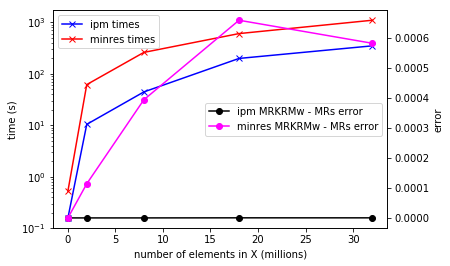

In [18]:
fig, ax1 = plt.subplots()
ax1.semilogy(size, t_ipm, label='ipm times', marker='x', color='blue')
ax1.semilogy(size, t_m, label='minres times', marker='x', color='red')
ax1.set_xlabel('number of elements in X (millions)')
ax1.legend(loc=2)
ax1.set_ylabel('time (s)')
ax2 = ax1.twinx()
ax2.plot(size, e_ipm, label='ipm MRKRMw - MRs error', marker='o', color='black')
ax2.plot(size, e_m, label='minres MRKRMw - MRs error', marker='o', color='magenta')
ax2.set_ylabel('error')
ax2.legend()
plt.show()
plt.close()